In [ ]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

: 

# Intro
- This PR makes sure that processes that depend on collisions get the right ones
- Conduction should only take ee or ii into account
- Diffusion should only take CX and IZ into account
- Neutral viscosity should take CX and IZ 
- Ion viscosity should take ii 

# IO

In [11]:
cs = dict()

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    # dict(name="master_base", id="sc3b-master_allcollisions_base", unnormalise_geom = True, use_xhermes = True),
    # dict(name="base_visc", id="sc3c-master_allcolls_visc", unnormalise_geom = True, use_xhermes = True),
    # dict(name="base_diff", id="sc4-3_selcoll_legacyon", unnormalise_geom = True, use_xhermes = True), 
    # dict(name="test", id="sc5-4_neut_diff_legacyoff", unnormalise_geom = True, use_xhermes = True),  
    # dict(name="master_base_nocx", id="sc3bc-nocx", unnormalise_geom = True, use_xhermes = True),
    # dict(name="master_base_lesscoll", id="sc3bd-lesscoll", unnormalise_geom = True, use_xhermes = True),
    # dict(name="all_legacyon", id="sc7-selcoll_condviscdiff_legon", unnormalise_geom = True, use_xhermes = True), 
    # dict(name="legacyoff_neut", id="sc7b-neutdiff_legacyoff", unnormalise_geom = True, use_xhermes = True),
    # dict(name="legacyoff_neutcond", id="sc7c-diff_cond_legacyoff", unnormalise_geom = True, use_xhermes = True),  
    # dict(name="legacyoff_ii_ei", id="sc7cb-ions_ii_electrons_ei_only", unnormalise_geom = True, use_xhermes = True),  
    # dict(name="legacyoff_ii_ee", id="sc7cc-ions_ii_electrons_ee_only", unnormalise_geom = True, use_xhermes = True),  
    # dict(name="no_ndiff_noparcond", id="sc7cd-no_perpdiff_no_parcond", unnormalise_geom = True, use_xhermes = True),  
    # dict(name="noneut", id="sc9a-ions_electrons_only", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="noei_cvode", id="sc9ab-no_ei", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="noei_beuler", id="sc9abx2-no_ei_beuler", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="noei_512", id="sc10-no_ei_512cells", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="noei_512_eiswap", id="sc10b-swap_ei_ee", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    dict(name="fix_ee", id="sc10b-fix_ee_braginskii", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    dict(name="swap_ee_ei", id="sc10c-swap_ee_ei", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  

]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"])


Unnormalising with xHermes
Unnormalising with xHermes


# Profiles

## Convergence

In [6]:
cs.keys()

dict_keys(['noei_512'])

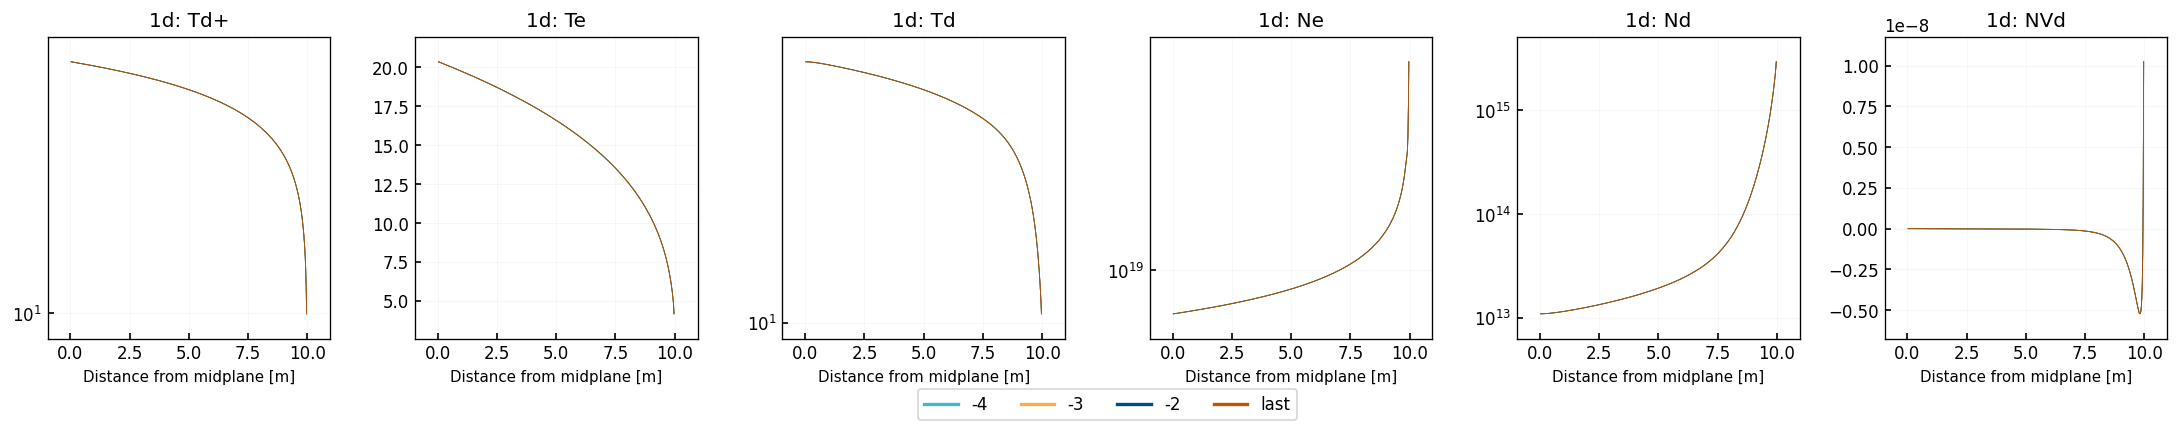

In [12]:
case = "noei_512"

lineplot(
    {
        # "start":cs[case].ds.isel(t=0),
        "-4":cs[case].ds.isel(t=-4),
        "-3":cs[case].ds.isel(t=-3),
        "-2":cs[case].ds.isel(t=-2),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Te", "Td", "Ne", "Nd", "NVd"],
    regions = ["1d"],
    lw = 0.5,
    markersize = 0
    # xlims=(8,10.3)
)

# Sheath conditions

In [30]:
# ds = cs["noneut"].ds
ds = cs["no_ndiff_noparcond"].ds

mp = constants("mass_p")
me = constants("mass_e")
qe = constants("q_e")
Zi = 1
AA = 2
sheath_ion_polytropic = 1

gamma_e = ds.options["sheath_boundary_simple"]["gamma_e"]
gamma_i = ds.options["sheath_boundary_simple"]["gamma_i"]

nesheath = ds["Ne"].isel(pos=-2)
tesheath = ds["Te"].isel(pos=-2)
tisheath = ds["Td+"].isel(pos=-2)
nvsheath = ds["NVd+"].isel(pos=-2) / (mp * AA)
vsheath = ds["Vd+"].isel(pos=-2)
dasheath = ds["da"].isel(pos=-2)
dvsheath = ds["dv"].isel(pos=-2)

# Ion flow speed
C_i = np.sqrt((sheath_ion_polytropic * qe * tisheath + Zi * qe * tesheath) / (AA * mp))

# Parallel heat flux in W/m^2.
# Note: Corrected for 5/2Pe convective thermal flux, and small electron kinetic energy flux
# so gamma_e is the total *energy* flux coefficient.
q_e = ((gamma_e - 2.5) * qe * tesheath - 0.5 * me * vsheath**2) * nesheath * vsheath
q_i = gamma_i * qe * tisheath * nesheath * vsheath

hfe = q_e * dasheath
hfi = q_i * dasheath
pf = vsheath * nesheath * dasheath

ds["hfe_sheath"] = hfe
ds["hfd+_sheath"] = hfi
ds["pfd+_sheath"] = pf

ds["hfe_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")
ds["hfd+_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")
ds["pfd+_sheath"].attrs.update(standard_name = "heat flux", units = "s^-1", source = "xHermes", long_name = "sheath particle flux")

# (nesheath * vsheath * mp * AA).plot()
# (ds["NVd+"].isel(pos = -2)).plot()
# pf.plot()
# (nvsheath * dasheath).plot()

In [6]:
ds["Ne"][-2] = (ds["Ne"][-2] + ds["Ne"][-3])/2

In [8]:
for param in ds.data_vars:
    if "pos" in ds[param].dims:
        ds[param][-2] = (ds[param][-2] + ds[param][-3])/2

In [15]:
ds = cs["noneut"].ds

# Guard replace to get position at boundaries
newpos = ds["pos"].values
attrs = ds["pos"].attrs
newpos[-2] = (newpos[-3] + newpos[-2])/2
newpos[1] = (newpos[1] + newpos[2])/2 

ds.assign_coords(pos = newpos)
ds["pos"].attrs.update(attrs)


In [4]:
cs.keys()

dict_keys(['noneut'])

## Comparison

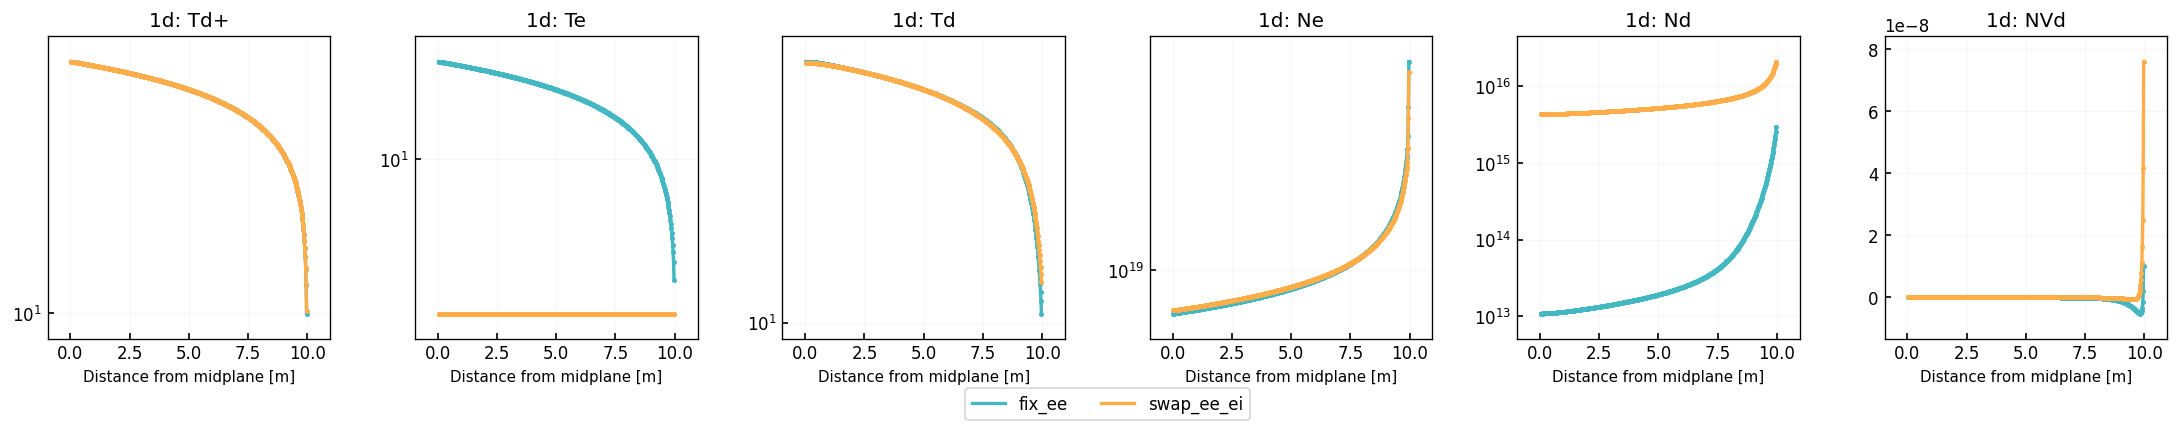

In [12]:
toplot = {}
for name in cs:
    ds = cs[name].ds
    if "t" in ds.dims:
        ds = ds.isel(t=-1)
    toplot[name] = ds

lineplot(
    toplot,
    clean_guards = True,
    params = ["Td+", "Te", "Td", "Ne", "Nd", "NVd"],
    regions = ["1d"],
    # xlims=(5,10.3)
)

# Check 1D neutral diffusion collisions

## Legacy on

In [6]:
cs.keys()

dict_keys(['all_legacyon'])

2D data detected


Text(0, 0.5, 'Collision frequency [s^-1]')

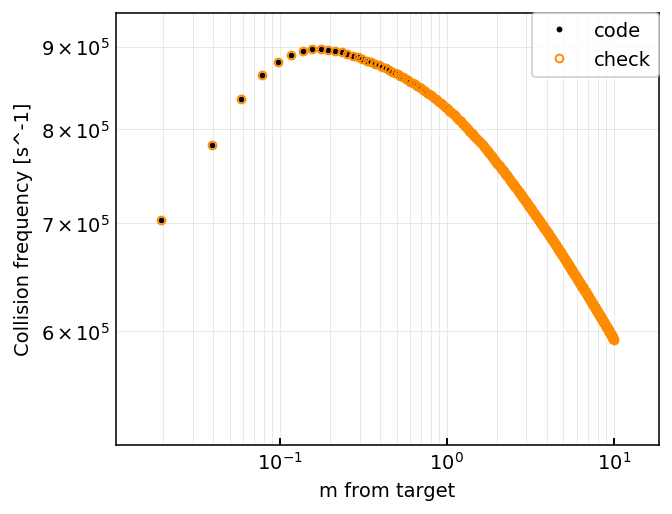

In [7]:
# ds = cs["base_diff_cond"].ds.isel(pos = slice(2,-2))
# ds = cs["master_base_lesscoll"].ds.isel(pos = slice(2,-2))
# ds = cs["master_base_nocx"].ds.isel(pos = slice(2,-2))
# ds = cs["master_base"].ds.isel(pos = slice(2,-2))
ds = cs["all_legacyon"].ds.isel(pos = slice(2,-2))
if "t" in ds.dims:
    ds = ds.isel(t=-1)
m = ds.metadata

Ta = ds["Td"].values
Ti = ds["Td+"].values
Te = ds["Te"].values
Tn = ds["Td"].values
Ne = ds["Ne"].values
Dn = ds["Dd_Dpar"].values
dneut = ds.options["neutral_parallel_diffusion"]["dneut"]

nt = NeutralTransport(ds, dict(Te = ds["Te"], Ta = ds["Td"], Ti = ds["Td+"], Ne = ds["Ne"], Na = ds["Nd"]))
nt.get_rates()

# Dn = dneut * Tn / (Mi * nu)
# Dn * Mi * nu = dneut * Tn
# nu = dneut * Tn / (Dn * Mi)
Kdn = dneut * Tn * constants("q_e") / (Dn * constants("mass_p")*2)
# Kcx = nt.k["cx"]
# Kcx = ds["Kdd+_cx"] #/ ds["Nd+"] * ds["Nd"]
Kiz = nt.k["iz"]
Knn = nt.k["nn"]
Kne = nt.k["ne"]
Kni = nt.k["ni"]

# Kdn_check = nt.k["cx"] + nt.k["ne"] + nt.k["nn"] + nt.k["ni"]
# Kdn_check = Kcx + Knn + Kne + Kni
# Kdn_check = Kcx + ds["Kdd_coll"] + ds["Kde_coll"] +ds["Kdd+_coll"]
Kdn_check =  ds["Kdd_coll"] + ds["Kde_coll"] +ds["Kdd+_coll"] + ds["Kdd+_cx"]

fig, ax = plt.subplots()
ax.plot(ds["pos"][-1] - ds["pos"], Kdn, marker = "o", ms = 2, lw = 0, label = "code", c = "k")
ax.plot(ds["pos"][-1] - ds["pos"], Kdn_check, marker = "o", markerfacecolor = "None",  c = "darkorange", lw = 0, ms = 4, label = "check")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("m from target")
ax.set_ylabel("Collision frequency [s^-1]")
# ax.set_xlim(-0.01,0.2)

## Legacy off

In [9]:
cs.keys()

dict_keys(['legacyoff_neut'])

2D data detected


Text(0, 0.5, 'Collision frequency [s^-1]')

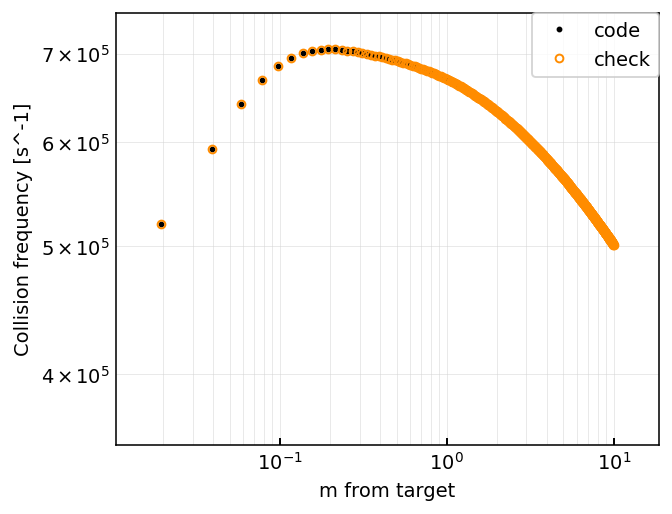

In [7]:
ds = cs["legacyoff_neut"].ds.isel(pos = slice(2,-2))

nt = NeutralTransport(ds, dict(Te = ds["Te"], Ta = ds["Td"], Ti = ds["Td+"], Ne = ds["Ne"], Na = ds["Nd"]))
nt.get_rates()

Kdn = ds.options["neutral_parallel_diffusion"]["dneut"] * ds["Td"] * constants("q_e") / (ds["Dd_Dpar"] * constants("mass_p")*2)

Kdn_check =  nt.k["iz"] +  ds["Kdd+_cx"]

fig, ax = plt.subplots()
ax.plot(ds["pos"][-1] - ds["pos"], Kdn, marker = "o", ms = 2, lw = 0, label = "code", c = "k")
ax.plot(ds["pos"][-1] - ds["pos"], Kdn_check, marker = "o", markerfacecolor = "None",  c = "darkorange", lw = 0, ms = 4, label = "check")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("m from target")
ax.set_ylabel("Collision frequency [s^-1]")

In [5]:
cs.keys()

dict_keys(['legacyoff_ii_ee'])

In [6]:
cs.keys()

dict_keys(['noei_512', 'fix_ee'])

# Export

In [7]:
ds = cs['fix_ee'].ds.isel(pos = slice(2,-2), t = -1)

df = pd.DataFrame()
df.index = ds["pos"].values
df.index.name = "y"

for param in ["Ne", "Nd", "Pe", "Pd+", "Pe", "Te", "Td+", "Td"]:
    df[param] = ds[param].values


df["NVd+"] = ds["NVd+"] / (constants("mass_p")*2)
df["NVd"] = ds["NVd"] / (constants("mass_p")*2)

df.to_csv(r"/ssd_scratch/hcases/selcoll/sc10b-fix_ee_braginskii.csv")



In [9]:
ds = cs["fix_ee"].ds

t = ds["t"].values
dt = t[-1] - t[-2]
total_t = dt * 100   # s
total_t *= 1000   # ms

total_t

5.219842377254466

In [3]:
cs["noei_512"].ds.dims

Frozen({'pos': 516, 't': 101})

# Check conduction

In [3]:
cs.keys()

dict_keys(['master_base', 'base_diff_cond'])

In [23]:
cs.keys()

dict_keys(['master_base', 'base_diff_cond'])

2D data detected


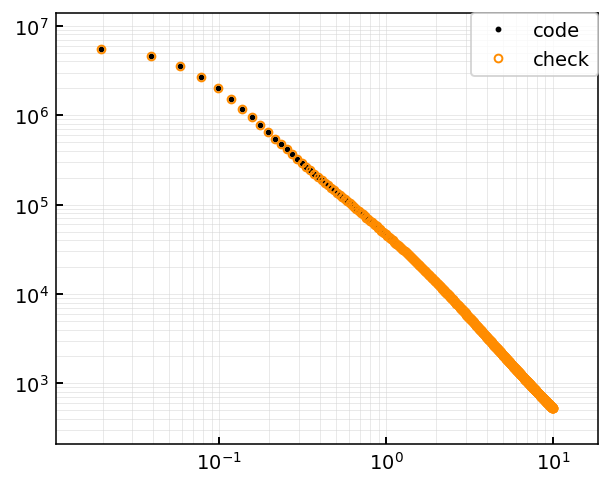

In [3]:
ds = cs["base_diff_cond"].ds.isel(pos = slice(2,-2))
if "t" in ds.dims:
    ds = ds.isel(t=-1)
m = ds.metadata

Ta = ds["Td"].values
Ti = ds["Td+"].values
Te = ds["Te"].values
Tn = ds["Td"].values
Ne = ds["Ne"].values
Dn = ds["Dd_Dpar"].values
dneut = ds.options["neutral_parallel_diffusion"]["dneut"]

nt = NeutralTransport(ds, dict(Te = ds["Te"], Ta = ds["Td"], Ti = ds["Td+"], Ne = ds["Ne"], Na = ds["Nd"]))
nt.get_rates()

# Dn = dneut * Tn / (Mi * nu)
# Dn * Mi * nu = dneut * Tn
# nu = dneut * Tn / (Dn * Mi)
Kcoll = ds["Kd+_cond"]

Kcx = ds["Kdd+_cx"]*ds["Nd"] / ds["Nd+"]
# Kcx = ds["Kdd+_cx"]

# Kdn_check = nt.k["cx"] + nt.k["ne"] + nt.k["nn"] + nt.k["ni"]
# Kcoll_check = Kii + Kin + Kcx + Kie
Kcoll_check = ds["Kd+d+_coll"] + ds["Kd+e_coll"] + ds["Kd+d_coll"] + Kcx

fig, ax = plt.subplots()
x = ds["pos"][-1] - ds["pos"]
ax.plot(x, Kcoll, marker = "o", ms = 2, lw = 0, label = "code", c = "k")
ax.plot(x, Kcoll_check, marker = "o", markerfacecolor = "None",  c = "darkorange", lw = 0, ms = 4, label = "check")
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_yscale("log")
ax.legend()
# ax.set_xlim(ax.get_xlim()[1], ax.get_xlim()[0])
ax.set_xscale("log")
# ax.set_xlim(-0.01,0.2)

## Electrons and neutrals

In [18]:
cs.keys()

dict_keys(['fix_ee', 'swap_ee_ei'])

In [23]:
constants?

Signature: constants(name)
Docstring: <no docstring>
File:      /ssd_scratch/scripts/sdtools/hermes3/utils.py
Type:      function

Text(0.5, 1.0, 'Electrons')

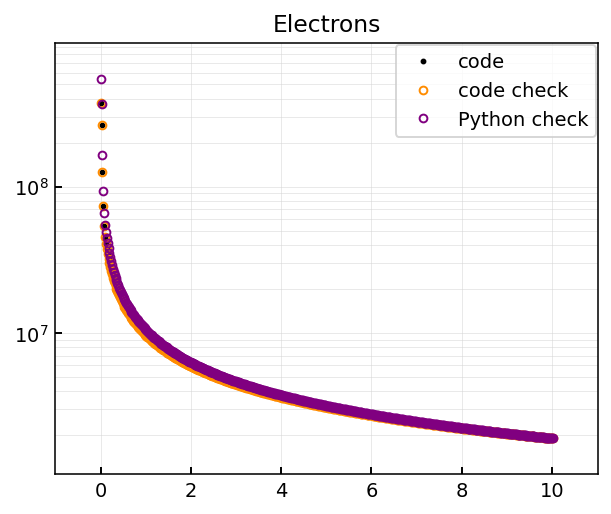

In [27]:
fig, ax = plt.subplots()



ds = cs["fix_ee"].ds.isel(t=-1)

tau_ee = 12 * np.pi**(3/2) * constants("e0")**2 * constants("mass_e")**(0.5) * (constants("q_e") * ds["Te"])**(3/2) / (12.22 * constants("q_e")**4 * ds["Ne"])
nu_ee = 1/tau_ee.values

x = ds["pos"][-1] - ds["pos"]
ax.plot(x, ds["Ke_cond"], marker = "o", ms = 2, lw = 0, label = "code", c = "k")
ax.plot(x, ds["Kee_coll"], marker = "o", markerfacecolor = "None",  c = "darkorange", lw = 0, ms = 4, label = "code check")
ax.plot(x, nu_ee, marker = "o", markerfacecolor = "None",  c = "purple", lw = 0, ms = 4, label = "Python check")
ax.set_yscale("log")
ax.legend()
ax.set_title("Electrons")

# fig, ax = plt.subplots()
# ax.plot(x, ds["Kd_cond"], marker = "o", ms = 2, lw = 0, label = "code", c = "k")
# ax.plot(x, ds["Kdd+_coll"] + ds["Kdd+_cx"] + ds["Kdd_coll"] + ds["Kde_coll"], marker = "o", markerfacecolor = "None",  c = "darkorange", lw = 0, ms = 4, label = "check")

# ax.set_yscale("log")
# ax.legend()
# ax.set_title("Neutrals")

In [30]:
1/nu_ee / np.sqrt(2)

array([3.71076281e-07, 3.71076281e-07, 3.70724819e-07, 3.70314579e-07,
       3.69857098e-07, 3.69363016e-07, 3.68842782e-07, 3.68305146e-07,
       3.67757095e-07, 3.67203892e-07, 3.66649093e-07, 3.66094945e-07,
       3.65542671e-07, 3.64992762e-07, 3.64445225e-07, 3.63899781e-07,
       3.63356003e-07, 3.62813454e-07, 3.62271702e-07, 3.61730382e-07,
       3.61189201e-07, 3.60647944e-07, 3.60106460e-07, 3.59564655e-07,
       3.59022475e-07, 3.58479901e-07, 3.57936930e-07, 3.57393574e-07,
       3.56849849e-07, 3.56305774e-07, 3.55761366e-07, 3.55216640e-07,
       3.54671605e-07, 3.54126270e-07, 3.53580641e-07, 3.53034719e-07,
       3.52488505e-07, 3.51942001e-07, 3.51395204e-07, 3.50848114e-07,
       3.50300731e-07, 3.49753052e-07, 3.49205075e-07, 3.48656801e-07,
       3.48108227e-07, 3.47559351e-07, 3.47010173e-07, 3.46460691e-07,
       3.45910906e-07, 3.45360815e-07, 3.44810419e-07, 3.44259717e-07,
       3.43708707e-07, 3.43157390e-07, 3.42605764e-07, 3.42053828e-07,
      

In [22]:
from sd1d.analysis import AMJUEL
from general.rates import AMJUEL_rates
amj = AMJUEL()
Krec = amj.amjuel_2d("rec", Te, Ne, data = AMJUEL_rates("rec"))
# Kiz = amj.amjuel_2d("rec", Te, Ne, data = AMJUEL_rates("iz"))

In [17]:
cs.keys()

dict_keys(['master_base', 'base_diff_cond'])

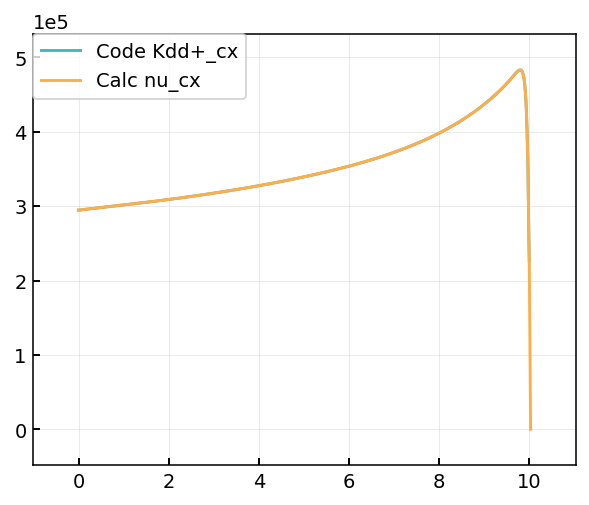

In [18]:
ds = cs["master_base"].ds.isel(t=-1)
m = ds.metadata

Ta = ds["Td"].values
Ti = ds["Td+"].values
Ne = ds["Ne"].values

ln_sigmav = -18.5028
Teff = (Ta + Ti)/2
lnT = np.log(Teff)
lnT_n = lnT.copy()

for b in [0.3708409, 7.949876e-3, -6.143769e-4, -4.698969e-4, -4.096807e-4, 1.440382e-4, -1.514243e-5, 5.122435e-7]:
    ln_sigmav += b * lnT_n
    lnT_n *= lnT
    
nu_cx = np.exp(ln_sigmav) * 1e-6 * Ne # convert from cm^3/s to m^3/s to 1/s

fig, ax = plt.subplots()
dist = ds["pos"].values


ax.plot(dist, ds["Kdd+_cx"], label = "Code Kdd+_cx")
ax.plot(dist, nu_cx, label = "Calc nu_cx")

ax.legend()
# ds["Kdd+_cx"].plot()

# Performance

Text(0.5, 1.0, 'Simulation speed')

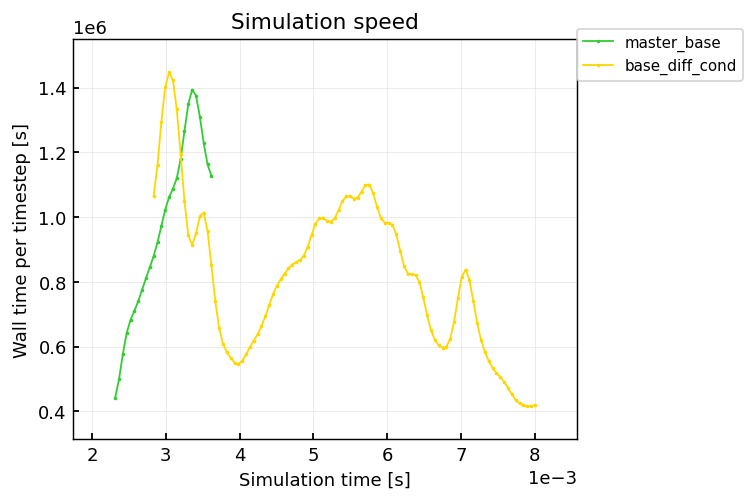

In [5]:
fig, ax = plt.subplots(dpi = 130)

colors = ["limegreen", "gold", "darkorange", "red", "firebrick", "skyblue", "navy"]

for i, case in enumerate(cs):
    ds = cs[case].ds
    wtime = ds["wtime"][:-1].values
    tstep = ds["t"].diff("t").values
    
    wtime_per_tstep = wtime/tstep
    time = ds["t"][:-1].values

    
    ax.plot(time, scipy.ndimage.gaussian_filter1d(wtime_per_tstep, 2), label = case, color = colors[i], lw = 1, marker = "o", ms = 1)
    
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Wall time per timestep [s]")
ax.set_title("Simulation speed")
# ax.set_xlim(None,0.614688)

# Other

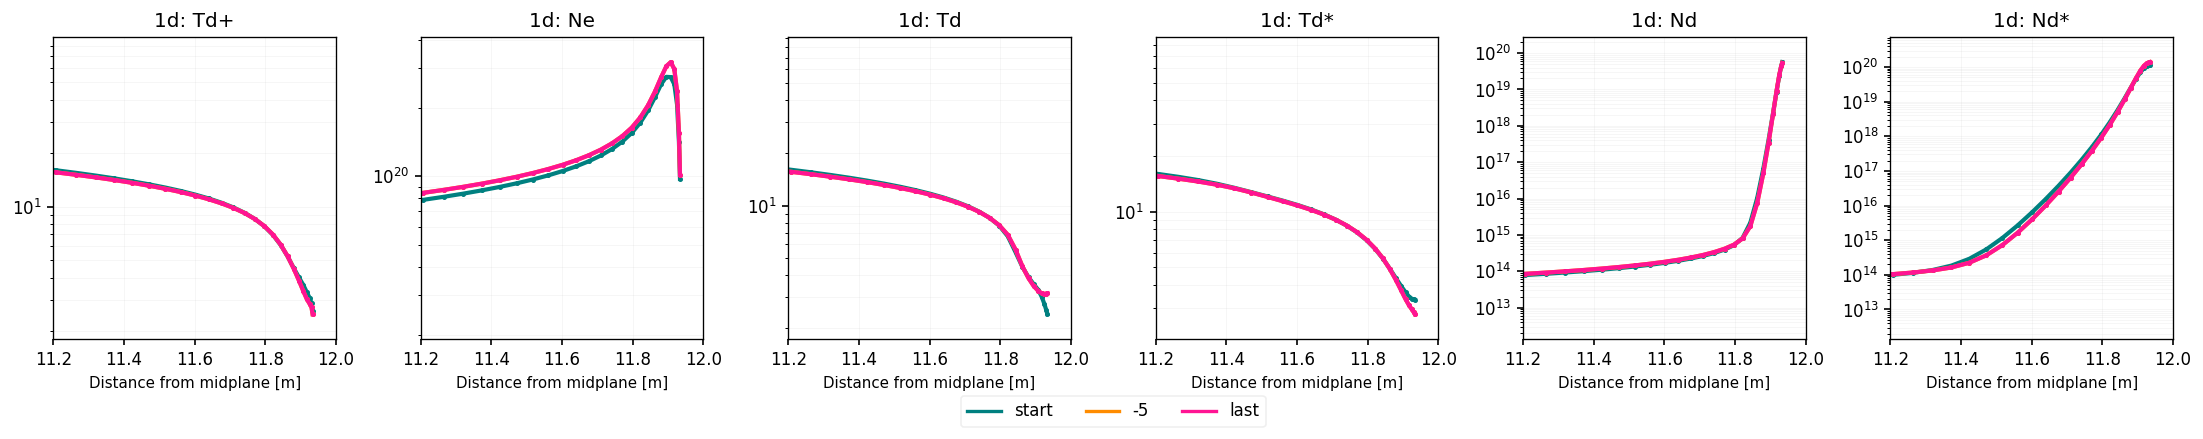

In [4]:
case = "neutbc"
lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-5":cs[case].ds.isel(t=-5),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Ne", "Td", "Td*", "Nd", "Nd*"],
    regions = ["1d"],
    xlims=(11.2,12)
)

# Check CX rate

In [47]:
def get_cx(Ta, Ti, Ne):
    ln_sigmav = -18.5028
    Teff = (Ta + Ti)/2
    lnT = np.log(Teff)
    lnT_n = lnT.copy()

    for b in [0.3708409, 7.949876e-3, -6.143769e-4, -4.698969e-4, -4.096807e-4, 1.440382e-4, -1.514243e-5, 5.122435e-7]:
        ln_sigmav += b * lnT_n
        lnT_n *= lnT
        
    nu_cx = np.exp(ln_sigmav) * 1e-6 * Ne # convert from cm^3/s to m^3/s
    
    return nu_cx